# Determining a prospective tariff for a telecommunications company

## Project description

**Brief information:** a telecommunications company offers its customers two tariff plans: "Smart" and "Ultra. The commercial department needs to understand which plan brings in more money in order to adjust the advertising budget. It is necessary to analyze customer behavior and conclude which plan is preferable for the telecom company.

**Objective:** Compare two tariff plans and determine the most promising plan with the highest revenue. 

## Data description

The dataset consists of several tables:
* table **users** (information about customers);
* table **calls** (information about calls made);
* table **messages** (information about sent messages);
* table **internet** (information about internet sessions);
* table **tariffs** (information about tariff plans).

The **users** table (information about cutomers) consists of the following columns:
* `user_id` — unique customer id;
* `first_name` — customer's first name;
* `last_name` — customer's last name;
* `age` — customer's age (in years);
* `reg_date` — tariff plan activation date (day, month, year);
* `churn_date` — termination date of the plan (if the value is missing, the plan was still in effect at the time of the data extraction).;
* `city` — client's city of residence;
* `tariff` — tariff plan name.

The **calls** table (information about calls made) consists of the following columns:
* `id` — unique call id;
* `call_date` — call date;
* `duration` — call duration in minutes;
* `user_id` — unique customer id.

The **messages** table (information about sent messages) consists of the following columns:
* `id` — unique message id;
* `message_date` — message date;
* `user_id` — unique customer id.

The **internet** table (information about internet sessions) consists of the following columns:
* `id` — unique session id;
* `mb_used` — amount of traffic spent per session (in megabytes);
* `session_date` — internet session date;
* `user_id` — customer's unique id.

The **tariffs** table (information about tariff plans) consists of the following columns:
* `tariff_name` — tariff plan name;
* `rub_monthly_fee` — monthly subscription fee in rubles;
* `minutes_included` — the number of minutes per month included in the subscription fee;
* `messages_included` — the number of messages per month included in the subscription fee;
* `mb_per_month_included` — internet traffic volume included in the subscription fee (in megabytes);
* `rub_per_minute` — cost of one minute of talk over the plan (for example, if the plan is 100 minutes per month, 101 minutes will be charged);
* `rub_per_message` — cost of a message over the tariff package;
* `rub_per_gb` — cost of one additional gigabyte of Internet traffic over the plan (1 gigabyte = 1024 megabytes).

## EDA

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st

In [2]:
# reading files
users = pd.read_csv('https://code.s3.yandex.net/datasets/users.csv')
users.name = 'users'
calls = pd.read_csv('https://code.s3.yandex.net/datasets/calls.csv')
calls.name = 'calls'
messages = pd.read_csv('https://code.s3.yandex.net/datasets/messages.csv')
messages.name = 'messages'
internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet.csv')
internet.name = 'internet'
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/tariffs.csv')
tariffs.name = 'tariffs'

In [3]:
# getting tables information
tables = [users, calls, messages, internet, tariffs]
for table in tables:
    print(table.info())
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None


<class 'panda

In [4]:
# calculating nans in the columns
for table in tables:
    print(table.isna().mean().sort_values(ascending=False))
    print('\n')

churn_date    0.924
user_id       0.000
age           0.000
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64


id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64


id              0.0
message_date    0.0
user_id         0.0
dtype: float64


Unnamed: 0      0.0
id              0.0
mb_used         0.0
session_date    0.0
user_id         0.0
dtype: float64


messages_included        0.0
mb_per_month_included    0.0
minutes_included         0.0
rub_monthly_fee          0.0
rub_per_gb               0.0
rub_per_message          0.0
rub_per_minute           0.0
tariff_name              0.0
dtype: float64




Note that there are missing values in the `churn_date` column of the `users` table. These nans indicate that the customer was still on their plan at the time of the database extraction. The missing values should therefore be left unchanged.

There are no missing values in the columns characterizing the amount of traffic used (`mb_used`), call duration (`duration`) and sent sms messages (`id`). However, not all users could perform these actions. Let's test this hypothesis by calculating the number of unique customer ids for each of the tables.

In [5]:
# calculating unique users for each table (except the table with tariff plans)
for table in tables[:4]:
    print(f'Number of users in the table {table.name}: {len(table["user_id"].unique())}')

Number of users in the table users: 500
Number of users in the table calls: 492
Number of users in the table messages: 426
Number of users in the table internet: 497


The hypothesis was confirmed. Not all users in the `users` table make phone calls, send messages, or use the Internet. This fact could potentially lead to missing values when merging tables into a single dataframe.

Let's check our columns for explicit and implicit duplicates and errors.

In [6]:
# checking tables content
for table in tables:
    display(table.head(10))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
# checking for explicit duplicates
for table in tables:
    print(f'Number of duplicates in the table {table.name}: {table.duplicated().sum()}')

Number of duplicates in the table users: 0
Number of duplicates in the table calls: 0
Number of duplicates in the table messages: 0
Number of duplicates in the table internet: 0
Number of duplicates in the table tariffs: 0


In [8]:
# checking for implicit duplicates
for table in tables:
    for column in table.columns:
        print("\n" + 'Table name ' + table.name)
        print("\n" + 'Column name ' + column)
        print(table[column].value_counts())


Table name users

Column name user_id
1024    1
1353    1
1366    1
1365    1
1364    1
       ..
1185    1
1184    1
1183    1
1182    1
1023    1
Name: user_id, Length: 500, dtype: int64

Table name users

Column name age
53    14
42    14
63    13
64    13
71    13
21    12
40    12
73    12
29    11
39    11
37    11
47    11
26    11
41    10
45    10
58    10
36    10
70    10
52    10
65     9
66     9
56     9
68     9
20     9
51     9
50     9
48     9
30     9
19     9
24     9
28     9
27     9
23     9
62     8
60     8
55     8
69     8
44     8
25     7
31     7
35     7
67     7
74     7
43     7
32     7
46     7
18     6
59     6
54     6
75     6
38     5
34     5
72     5
33     5
22     5
57     4
49     4
61     3
Name: age, dtype: int64

Table name users

Column name churn_date
2018-12-21    2
2018-12-09    2
2018-10-03    2
2018-10-14    2
2018-12-03    2
2018-11-26    1
2018-12-16    1
2018-10-25    1
2018-11-13    1
2018-10-05    1
2018-12-23    1
2018-08-31 

There are columns with zero values in the `calls` and `internet` tables - a column with the duration of the call (`duration`) and a column with the amount of traffic during the internet session (`mb_used`). We can assume that

* zero call duration may indicate that a call was not answered;
* zero traffic volume of the Internet session may indicate that during the connection service packets were exchanged between the tower and the phone and the non-tariffing traffic threshold was not exceeded. Usually such connections are typical for 4G networks. Let's check this hypothesis and look at the table of Internet sessions with zero traffic.

In [9]:
# internet sessions with zero traffic
internet.query('mb_used == 0')

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


We can see from the table that there are at least two clients with IDs 1000 and 1499 that had registered Internet sessions with zero traffic. Let's check if they still had Internet sessions and add up the number of megabytes used, grouping the table by user.

In [10]:
# grouping internet table by users
internet.groupby('user_id')['mb_used'].agg('sum').sort_values()

user_id
1399      4603.52
1192      9031.84
1062     11072.78
1069     11348.27
1406     11430.43
          ...    
1330    336373.28
1185    343533.71
1180    348211.20
1240    376237.47
1385    376397.38
Name: mb_used, Length: 497, dtype: float64

So there are no sessions with completely zero traffic in this column, so we should keep the zero values.

For further work, we need to merge the tables into a single dataframe. However, before we merge and analyze the data, we'll convert the date columns to pandas' datetime format.

Before merging the tables, we'll group the tables of calls, messages, and web traffic by unique user ID and month in which these services were provided to the customer.

We'll also convert the traffic used into gigabytes. For the time being, the call duration and traffic volume should be rounded, then we'll convert them to an integer format.

In the final dataframe, we'll highlight the column with the month values in which the services were provided. To test the hypotheses, we'll also add the amount of revenue for each user to the dataframe.

### Conclusions

* **We'll keep zero values in the call duration and Internet traffic columns. Calls with zero duration are unanswered calls. Zero traffic Internet sessions are the exchange of service data packets;**
* **We'll convert columns containing dates to the Pandas' datetime format;**
* **The tables should be merged into a single dataframe, grouping the calls, messages, and web traffic tables by unique user IDs and the month in which the services were provided to the customer;**
* **We'll convert the spent Internet traffic to gigabytes. Traffic volume, amount of messages and call duration we'll convert to integer type by rounding them up;**
* **In the final dataframe, we'll create a column with the month in which the customer received services. To test the hypotheses, we'll also add the amount of revenue for each user to the dataframe.**

## Data pre-processing

Before creating pivot tables by unique user IDs and months, we should convert columns containing dates to the Pandas datetime format.

In [11]:
# converting columns into pandas datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Next, we'll create a column for the month of service in each of the service volume tables.

In [12]:
# creating columns with months
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

In [13]:
# rounding up calls duration
calls['duration'] = np.ceil(calls['duration'])

Before creating a single dataframe, we'll create pivot tables with the volume of services provided grouped by unique user IDs and months.

In [14]:
# calls pivot table 
calls_pivoted = (calls
                 .pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
                 .reset_index())

In [15]:
# internet sessions pivot table
internet_pivoted = (internet
                    .pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
                    .reset_index())

In [16]:
# sent messages pivot table
messages_pivoted = (messages
                    .pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
                    .reset_index())
messages_pivoted.rename(columns={'id': 'messages'}, inplace=True)

The next step is to merge the created pivot tables using unique IDs and months as keys. 

In [17]:
#merging created pivot tables
services_provided = (pd.merge(
    pd.merge(calls_pivoted, internet_pivoted, on=['user_id', 'month'], how='outer'), 
    messages_pivoted, on=['user_id', 'month'], how='outer'))

In [18]:
# checking created dataframe
display(services_provided)

,user_id,month,duration,mb_used,messages
0,1000,5,159.0,2253.49,22.0
1,1000,6,172.0,23233.77,60.0
2,1000,7,340.0,14003.64,75.0
3,1000,8,408.0,14055.93,81.0
4,1000,9,466.0,14568.91,57.0
...,...,...,...,...,...
3209,1489,8,NaN,11050.56,17.0
3210,1489,9,NaN,17206.30,32.0
3211,1489,10,NaN,19559.44,21.0
3212,1489,11,NaN,17491.56,20.0


We'll merge tables of users and plans offered by the telecom company into the created dataframe with the volume of services provided.

In [19]:
# making single dataframe with tariffs and the volume of services provided
df = (pd.merge(
    pd.merge(users, services_provided, on=['user_id'], how='left'), 
    tariffs, left_on='tariff', right_on='tariff_name'))

In [20]:
# check
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.0,159.0,2253.49,22.0,1000,30720,3000,1950,150,1,1,ultra
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.0,172.0,23233.77,60.0,1000,30720,3000,1950,150,1,1,ultra
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.0,340.0,14003.64,75.0,1000,30720,3000,1950,150,1,1,ultra
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,408.0,14055.93,81.0,1000,30720,3000,1950,150,1,1,ultra
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.0,466.0,14568.91,57.0,1000,30720,3000,1950,150,1,1,ultra


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   age                    3216 non-null   int64  
 2   churn_date             189 non-null    object 
 3   city                   3216 non-null   object 
 4   first_name             3216 non-null   object 
 5   last_name              3216 non-null   object 
 6   reg_date               3216 non-null   object 
 7   tariff                 3216 non-null   object 
 8   month                  3214 non-null   float64
 9   duration               3174 non-null   float64
 10  mb_used                3203 non-null   float64
 11  messages               2717 non-null   float64
 12  messages_included      3216 non-null   int64  
 13  mb_per_month_included  3216 non-null   int64  
 14  minutes_included       3216 non-null   int64  
 15  rub_

The final dataframe consists of columns with missing values: 
* internet traffic volume, 
* call duration, 
* month, 
* number of messages sent.

Presumably, the columns with service volumes provided should be filled with zeros because these users didn't make calls, send messages, or use mobile Internet. To test this hypothesis, we'll slice our dataframe with such users.

In [22]:
# dataframe slice with users, which do not use mobile internet
df.query('mb_used.isna()')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
243,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,NaN,NaN,NaN,1000,30720,3000,1950,150,1,1,ultra
477,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,5.0,220.0,NaN,21.0,1000,30720,3000,1950,150,1,1,ultra
478,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,6.0,230.0,NaN,38.0,1000,30720,3000,1950,150,1,1,ultra
479,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,7.0,253.0,NaN,37.0,1000,30720,3000,1950,150,1,1,ultra
480,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,8.0,253.0,NaN,41.0,1000,30720,3000,1950,150,1,1,ultra
481,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,9.0,223.0,NaN,32.0,1000,30720,3000,1950,150,1,1,ultra
482,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,10.0,315.0,NaN,35.0,1000,30720,3000,1950,150,1,1,ultra
483,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,11.0,272.0,NaN,29.0,1000,30720,3000,1950,150,1,1,ultra
484,1273,46,NaN,Курган,Рэм,Корнилов,2018-05-15,ultra,12.0,260.0,NaN,39.0,1000,30720,3000,1950,150,1,1,ultra
714,1377,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra,2.0,179.0,NaN,2.0,1000,30720,3000,1950,150,1,1,ultra


Note that some users have missing values for call duration and sent messages. At the same time, these values are randomly distributed. Therefore, we'll fill the gaps in these columns with zeros.

In [23]:
# filling nans with zeros
df['messages'] = df['messages'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)
df['duration'] = df['duration'].fillna(0)

Let's take a look at rows with nans in the month column.

In [24]:
# rows with nans in month column
df.query('month.isna()')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
243,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,0.0,0.0,0.0,1000,30720,3000,1950,150,1,1,ultra
2619,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,0.0,0.0,0.0,50,15360,500,550,200,3,3,smart


In [25]:
internet.query('user_id == 1128 or user_id == 1371')

,Unnamed: 0,id,mb_used,session_date,user_id,month


The sliced dataframe includes two users who churned in December 2018, a week or two after the rates were set. However, they may have already been billed for the first month. Therefore, missing values in the Month column should be filled in with December.

In [26]:
df['month'] = df['month'].fillna(12)

Now let's create a column with the Internet traffic consumed in gigabytes, rounded up.

In [27]:
# consumed internet traffic
df['gb_used'] = np.ceil(df['mb_used'] / 1024)

In [28]:
# creating a column with the amount of traffic included in the tariff plan
df['gb_per_month_included'] = df['mb_per_month_included'] / 1024

Let's convert the month, the amount of included and consumed Internet traffic, the duration of calls and the number of sent messages to integer type.

In [29]:
# converting using loop
columns_to_int = ['month', 'gb_used', 'duration', 'messages', 'gb_per_month_included']
for column in columns_to_int:
    df[column] = df[column].astype('int')

In [30]:
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,gb_per_month_included
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159,...,1000,30720,3000,1950,150,1,1,ultra,3,30
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172,...,1000,30720,3000,1950,150,1,1,ultra,23,30
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340,...,1000,30720,3000,1950,150,1,1,ultra,14,30
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408,...,1000,30720,3000,1950,150,1,1,ultra,14,30
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466,...,1000,30720,3000,1950,150,1,1,ultra,15,30


To test the hypothesis about which plan brings in more revenue, let's create a column with the revenue calculation for each user. To do this, we'll create a function that compares the volume of services consumed with the volume included in each plan.

In [31]:
# revenue calculating function that iterates each row and compares the volume of provided services with those included in the tariff plan
def revenue(row):
    subscription_fee = row['rub_monthly_fee']
    revenue_per_call = 0
    revenue_per_messages = 0
    revenue_per_gb = 0
    if row['duration'] > row['minutes_included']:
        revenue_per_call += row['rub_per_minute'] * (row['duration'] - row['minutes_included'])
    if row['duration'] <= row['minutes_included']:
        revenue_per_call += revenue_per_call
    if row['messages'] > row['messages_included']:
        revenue_per_messages += row['rub_per_message'] * (row['messages'] - row['messages_included'])
    if row['messages'] <= row['messages_included']:
        revenue_per_messages += revenue_per_messages
    if row['gb_used'] > row['gb_per_month_included']:
        revenue_per_gb += row['rub_per_gb'] * (row['gb_used'] - row['gb_per_month_included'])
    if row['gb_used'] <= row['gb_per_month_included']:
        revenue_per_gb += revenue_per_gb
    return revenue_per_call + revenue_per_messages + revenue_per_gb + subscription_fee

In [32]:
# creating a column with the revenue
df['monthly_revenue'] = df.apply(revenue, axis=1)

In [33]:
# check
pd.set_option('max_columns', 23)
df.query('duration > minutes_included or messages > messages_included or gb_used > gb_per_month_included')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,gb_per_month_included,monthly_revenue
50,1024,73,NaN,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,11,1146,43107.47,0,1000,30720,3000,1950,150,1,1,ultra,43,30,3900
51,1024,73,NaN,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,12,949,35948.13,0,1000,30720,3000,1950,150,1,1,ultra,36,30,2850
78,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,7,209,35177.91,52,1000,30720,3000,1950,150,1,1,ultra,35,30,2700
97,1060,46,NaN,Калуга,Яков,Рудаков,2018-11-24,ultra,12,1233,43931.36,52,1000,30720,3000,1950,150,1,1,ultra,43,30,3900
228,1124,54,NaN,Махачкала,Альбин,Андрианов,2018-09-24,ultra,10,1225,49745.69,121,1000,30720,3000,1950,150,1,1,ultra,49,30,4800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3210,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,9,471,22134.41,44,50,15360,500,550,200,3,3,smart,22,15,1950
3211,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,10,247,20579.36,42,50,15360,500,550,200,3,3,smart,21,15,1750
3213,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,10,449,17788.51,48,50,15360,500,550,200,3,3,smart,18,15,1150
3214,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,11,612,17963.31,59,50,15360,500,550,200,3,3,smart,18,15,1513


### Conclusions

* **Month columns were created in the tables of service volumes. Pivot tables were then created for calls, traffic volume, and number of messages sent, grouped by unique customer ID and month. A common dataframe containing information about users was created;**
* **In the resulting dataset, missing values were identified and filled in. Missing values in the volume of services can mean that these customers didn't send messages, didn't make calls, and didn't use mobile Internet. Missing values in such columns are filled with zeros;**
* **Two users who churned in December 2018 were identified in the dataset. The NANs for these users are filled with December values, as the tariff fee is typically charged at the time of signing up for the tariff plan;**
* **Monthly traffic volume consumed and included in the plan is converted to gigabytes. The columns with the volume of service provided and month have been converted to integer type;**
* **To determine a more perspective tariff plan, a column with the amount of revenue has been added to the dataframe.**

## EDA

The first step of EDA is to create a histogram of sent messages, call duration, and gigabyte usage for each of the rate plans.

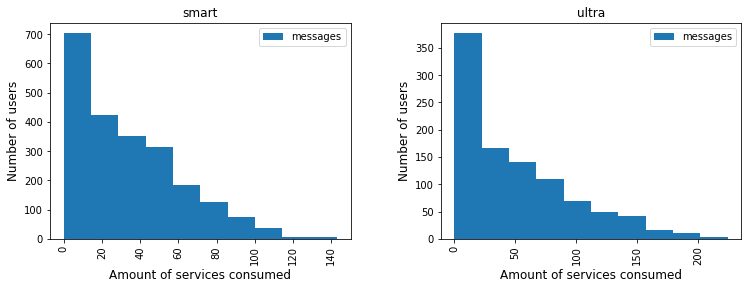

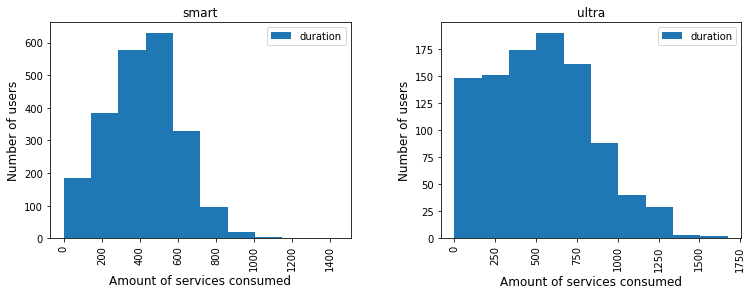

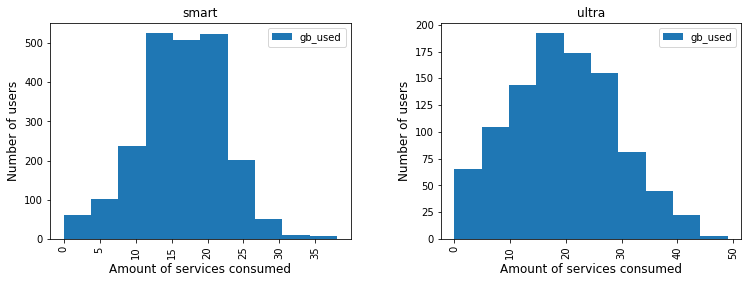

In [34]:
# columns list
hist_plots = ['messages', 'duration', 'gb_used']
# plotting histograms with a loop
for column in hist_plots:
    ax = df.hist(legend=True, by='tariff', column=column, figsize=(12,4))
    for x in ax:
        x.set_xlabel('Amount of services consumed', size=12)
        x.set_ylabel('Number of users', size=12)
    plt.show()

In [35]:
# calculating var, std and mean
df.pivot_table(index='tariff_name', values=['messages', 'duration', 'gb_used'], aggfunc=('mean', 'var', 'std', 'count')).round(2)

duration                            gb_used                      \
               count    mean     std        var   count   mean   std    var   
tariff_name                                                                   
smart         2230.0  417.75  190.48   36281.39  2230.0  16.32  5.76  33.13   
ultra          986.0  526.09  317.89  101052.49   986.0  19.47  9.87  97.38   

            messages                         
               count   mean    std      var  
tariff_name                                  
smart         2230.0  33.37  28.23   796.96  
ultra          986.0  49.31  47.81  2285.42

* User behavior by number of messages sent for the two tariffs is skewed to the right - the behavior of the two groups is similar. It should be noted that there are Smart tariff users who exceed the set limits (~30% of users), while no Ultra tariff user has exceeded the limit of 1000 messages. More than 50% of the tariff users send about the same number of messages per month (60). The column with the number of messages sent is characterized by a high spread in relation to the average value, which may indicate a different user behavior (perhaps the age group of customers uses this service differently). Most users require about 60 messages per month.
* The histograms of user behavior by call duration are also skewed to the right. Note that users' behavior is similar to the way they send messages. There are users of smart tariffs who exceed the limits set in the package (their share is ~ 20%). At the same time, none of the Ultra tariff users exceeded the limits set in the provided package. Users of smart tariffs mostly do not use more than 700 minutes, while users of ultra tariffs use only 1000 minutes. The duration of calls is also characterized by a wide range of relative averages.
* The histograms by number of gigabytes spent are also skewed to the right. Users of smart tariffs are more likely to exceed the limits set by the tariff. The share of these users is ~50%. This may indicate that the users do not have enough traffic volume. The proportion of Ultra tariff users who exceed the limits is lower than that of Smart tariff users. The traffic volume consumed is also characterized by a high spread relative to the average.

Let's see how users behave depending on their age. We will divide the age range into 5 equal groups. For the analysis, we use the median because the distributions are characterized by a high spread of the relative mean.

In [36]:
# cutting into groups
df['age_group'] = pd.qcut(df['age'], 5)

In [37]:
# pivot table by age and the tariff plan
df.pivot_table(index=['tariff_name','age_group'], values=['messages', 'duration', 'gb_used'], aggfunc='median')

duration  gb_used  messages
tariff_name age_group                                  
smart       (17.999, 29.0]     416.0       17      24.0
            (29.0, 41.0]       395.0       17      26.0
            (41.0, 52.0]       429.0       16      28.0
            (52.0, 64.0]       425.5       17      30.0
            (64.0, 75.0]       452.5       17      32.0
ultra       (17.999, 29.0]     416.5       21      51.0
            (29.0, 41.0]       521.0       16      28.0
            (41.0, 52.0]       581.0       18      25.0
            (52.0, 64.0]       563.0       19      49.0
            (64.0, 75.0]       533.0       21      26.5

In general, the behavior of the age groups of the two tariffs in terms of call duration is almost identical. With increasing age, there is a slight increase in the median of their duration. On the other hand, the volume of traffic consumed by users of smart tariffs does not change significantly by age group. The largest number of messages is sent by younger users of Ultra tariffs.

Let's look at the seasonality in the volume of services consumed.

In [38]:
# pivot table by month and tariff plans
df.pivot_table(index=['tariff_name', 'month'], values=['messages', 'duration', 'gb_used'], aggfunc= 'median')

duration  gb_used  messages
tariff_name month                             
smart       1         162.5      7.0      15.0
            2         258.0     13.0      20.0
            3         409.0     16.0      23.0
            4         368.5     14.0      28.0
            5         433.0     16.0      30.0
            6         400.0     16.0      28.0
            7         414.0     16.0      29.0
            8         432.0     17.0      27.0
            9         435.0     16.0      30.0
            10        427.5     17.0      30.0
            11        428.5     17.0      28.0
            12        471.0     18.0      29.0
ultra       1         382.0     15.0      32.0
            2         168.0      7.5       5.5
            3         403.0     18.0      20.0
            4         453.0     17.0      17.0
            5         519.0     19.0      25.0
            6         479.0     19.5      27.5
            7         542.0     20.0      38.0
            8         500.0     19.0      40.0
            9         520.0     20.0      43.0
            10        533.0     20.0      49.0
            11        546.0     18.5      43.0
            12        582.5     22.0      50.5

It should be noted that the volume of services consumed increases towards the end of the year - we can assume that this is due to the beginning of the New Year, when users begin to actively congratulate each other.

### Conclusions

* **Seasonality should be noted in the volume of services consumed - the volume increases at the end of the year. This is most likely connected with the holidays, when people try to congratulate each other on the New Year;** 
* **In general, the behavior of age groups in terms of call duration is almost identical between the two plans;**
* **In general, the behavior of the age groups in the two tariff groups in terms of call duration is almost identical. With increasing age, there is a slight increase in the median of their duration. On the other hand, the volume of traffic consumed by users of smart tariffs does not vary significantly by age group. The youngest users of Ultra tariffs send the largest number of messages;**.
* **For Smart tariff users it is probably necessary to expand the product line - to offer them a tariff with a higher number of messages, calls and traffic volume. For users of the Ultra tariff it is possible to reduce the limit of messages and calls included in the package. Thus, for users of the Ultra tariff it is possible to reduce the limit for the number of calls to 1000 minutes per month and the number of messages to 100;**.
* **It should be noted that there is a need to develop personalized tariffs, i.e. the user himself can determine the number of services he needs in a month.** 

## Hypothesis testing

### Analyzing outliers

Before testing hypotheses about the amount of revenue generated by the two plans, the dataset should be analyzed for outliers in the amount of services consumed.

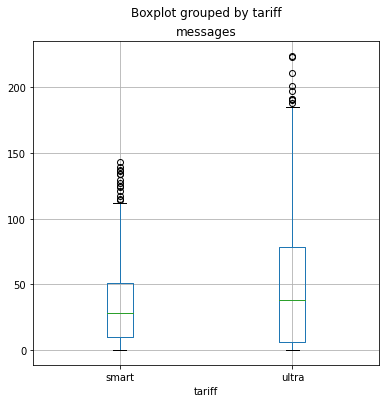

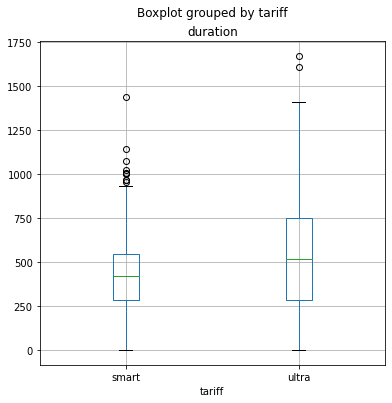

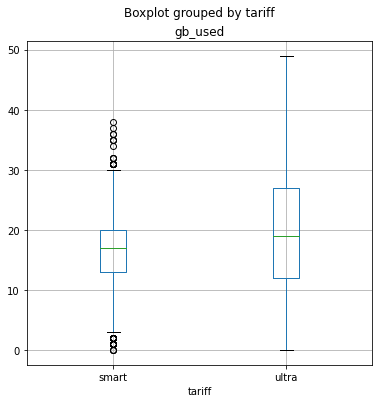

In [39]:
# boxplots for services consumed
for column in hist_plots:
    df.boxplot(column=column, figsize=(6,6), by='tariff')
    plt.show()

The graphs show that there are outliers in the data not for all the columns characterizing the volume of services provided. Thus, for the smart tariff, the outliers are observed in the columns:
* in the number of messages sent;
* in the duration of calls;
* in the volume of Internet traffic consumed.

For the number of sent messages the outliers are more than ~110 messages, for the duration of calls - more than ~900 minutes, for the amount of consumed traffic - less than ~2 and more than ~30 GB.

For the Ultra tariff the outliers are observed in columns:
* in the number of sent messages;
* duration of calls.

So, for the number of sent messages the outliers are more than ~180 messages, and for the duration of calls - more than ~1400 minutes.

Let's filter the dataset based on the above outliers. To do this, calculate the upper and lower limits for outlier filtering, and create a column in the dataset that cuts off the outliers.

In [40]:
# calculating lower and upper bounds q1-(1.5*iqr) q3+(1.5*iqr) by tariff plans
smart_messages_upper = df.query('tariff_name == "smart"')['messages'].quantile(0.75) + (1.5 * (df.query('tariff_name == "smart"')['messages'].quantile(0.75) - df.query('tariff_name == "smart"')['messages'].quantile(0.25)))
smart_duration_upper = df.query('tariff_name == "smart"')['duration'].quantile(0.75) + (1.5 * (df.query('tariff_name == "smart"')['duration'].quantile(0.75) - df.query('tariff_name == "smart"')['duration'].quantile(0.25)))
smart_gb_lower = df.query('tariff_name == "smart"')['gb_used'].quantile(0.25) - (1.5 * (df.query('tariff_name == "smart"')['gb_used'].quantile(0.75) - df.query('tariff_name == "smart"')['gb_used'].quantile(0.25)))
smart_gb_upper = df.query('tariff_name == "smart"')['gb_used'].quantile(0.75) + (1.5 * (df.query('tariff_name == "smart"')['gb_used'].quantile(0.75) - df.query('tariff_name == "smart"')['gb_used'].quantile(0.25)))
ultra_messages_upper = df.query('tariff_name == "ultra"')['messages'].quantile(0.75) + (1.5 * (df.query('tariff_name == "ultra"')['messages'].quantile(0.75) - df.query('tariff_name == "ultra"')['messages'].quantile(0.25)))
ultra_duration_upper = df.query('tariff_name == "ultra"')['duration'].quantile(0.75) + (1.5 * (df.query('tariff_name == "ultra"')['duration'].quantile(0.75) - df.query('tariff_name == "ultra"')['duration'].quantile(0.25)))
print(f'Upper bound for messages (smart): {smart_messages_upper}')
print(f'Upper bound for calls (smart): {smart_duration_upper}')
print(f'Lower bound for traffic (smart): {smart_gb_lower}')
print(f'Upper bound for traffic (smart): {smart_gb_upper}')
print(f'Upper bound for messages (ultra): {ultra_messages_upper}')
print(f'Upper bound for calls (ultra): {ultra_duration_upper}')

Upper bound for messages (smart): 112.5
Upper bound for calls (smart): 939.5
Lower bound for traffic (smart): 2.5
Upper bound for traffic (smart): 30.5
Upper bound for messages (ultra): 187.875
Upper bound for calls (ultra): 1455.625


In [41]:
# function which filters values (row as an argument, output - keep or not to keep the row 0/1)
def keep_row(row):
    if row['tariff'] == 'smart':
        if (row['messages'] <= smart_messages_upper and row['duration'] <= smart_duration_upper and row['gb_used'] >= smart_gb_lower and row['gb_used'] <= smart_gb_upper):
            return True
        else:
            return False
    if row['tariff'] == 'ultra':
        if (row['messages'] <= ultra_messages_upper and row['duration'] <= ultra_duration_upper):
            return True
        else:
            return False

In [42]:
# creating a column
df['keep_row'] = df.apply(keep_row, axis=1)

In [43]:
# check
pd.set_option('max_columns', 25)
df.query('keep_row == False')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,gb_per_month_included,monthly_revenue,age_group,keep_row
52,1028,20,NaN,Тверь,Рустем,Евсеев,2018-10-02,ultra,10,954,22499.75,223,1000,30720,3000,1950,150,1,1,ultra,22,30,1950,"(17.999, 29.0]",False
285,1165,19,NaN,Самара,Алексей,Медведев,2018-10-14,ultra,11,232,42144.47,197,1000,30720,3000,1950,150,1,1,ultra,42,30,3750,"(17.999, 29.0]",False
286,1165,19,NaN,Самара,Алексей,Медведев,2018-10-14,ultra,12,278,31942.39,224,1000,30720,3000,1950,150,1,1,ultra,32,30,2250,"(17.999, 29.0]",False
293,1167,30,NaN,Кемерово,Клавдия,Абдулина,2018-09-29,ultra,10,727,15778.63,190,1000,30720,3000,1950,150,1,1,ultra,16,30,1950,"(29.0, 41.0]",False
396,1231,63,NaN,Чебоксары,Касьян,Авдюков,2018-05-23,ultra,6,0,27825.92,201,1000,30720,3000,1950,150,1,1,ultra,28,30,1950,"(52.0, 64.0]",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,1484,55,NaN,Екатеринбург,Илзе,Абалдуева,2018-08-04,smart,11,334,16790.84,121,50,15360,500,550,200,3,3,smart,17,15,1163,"(52.0, 64.0]",False
3157,1486,35,NaN,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,10,38,407.66,1,50,15360,500,550,200,3,3,smart,1,15,550,"(29.0, 41.0]",False
3158,1486,35,NaN,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,11,764,36266.11,96,50,15360,500,550,200,3,3,smart,36,15,5680,"(29.0, 41.0]",False
3159,1486,35,NaN,Нижний Новгород,Матвей,Моргунов,2018-10-31,smart,12,1007,38552.45,83,50,15360,500,550,200,3,3,smart,38,15,6770,"(29.0, 41.0]",False


In [44]:
# filtering dataset
good_df = df.query('keep_row == True')

In [45]:
good_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,duration,mb_used,messages,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,gb_per_month_included,monthly_revenue,age_group,keep_row
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,159,2253.49,22,1000,30720,3000,1950,150,1,1,ultra,3,30,1950,"(41.0, 52.0]",True
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,172,23233.77,60,1000,30720,3000,1950,150,1,1,ultra,23,30,1950,"(41.0, 52.0]",True
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,340,14003.64,75,1000,30720,3000,1950,150,1,1,ultra,14,30,1950,"(41.0, 52.0]",True
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8,408,14055.93,81,1000,30720,3000,1950,150,1,1,ultra,14,30,1950,"(41.0, 52.0]",True
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9,466,14568.91,57,1000,30720,3000,1950,150,1,1,ultra,15,30,1950,"(41.0, 52.0]",True


### Hypothesis 1.  The average revenue of Ultra and Smart plan users is different.

The comparison is made for two general populations of samples taken from them.
In this case, the null hypothesis should be that the average revenue of Ultra plan users is equal to the average revenue of Smart plan users.

**H0 - average revenue of the users of the two tariffs is not different.**

**H1 - average revenue of users of the two plans is different**.

In [46]:
revenue_ultra = list(good_df.query('tariff_name == "ultra"')['monthly_revenue'])

In [47]:
revenue_smart = list(good_df.query('tariff_name == "smart"')['monthly_revenue'])

To test the hypothesis we use ttest_ind. We take 5% (0.05) as an acceptable p-value

In [48]:
alpha = 0.05
results = st.ttest_ind(
    revenue_ultra, 
    revenue_smart)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 6.347584293095199e-195
Reject the null hypothesis


In [49]:
print(f' Average revenue for ultra tariff: {sum(revenue_ultra) / len(revenue_ultra)}')
print(f' Average revenue for smart tariff: {sum(revenue_smart) / len(revenue_smart)}')

 Average revenue for ultra tariff: 2067.230769230769
 Average revenue for smart tariff: 1261.286443825441


Thus, the test results indicate that the probability of obtaining the observed result if the null hypothesis is true is less than the given level of significance (the probability of obtaining results confirming the null hypothesis is extremely small). This allows us to reject the null hypothesis of equality of the average user revenue of the two tariffs in favor of the alternative hypothesis - the average revenue of the two tariffs is different.

### Hypothesis 2.  The average revenue of Moscow users differs from other regions.

Similarly to the previous hypothesis, the comparison will be made for two general populations of samples taken from them.
In this case, the null hypothesis should be formulated so that the average revenue of users from Moscow is equal to the average revenue of users from other cities.

**H0 - average user revenue for Moscow and other cities does not differ from each other**

**H1 - average user revenue for Moscow and other cities is different**

In [50]:
revenue_moscow = list(good_df.query('city == "Москва"')['monthly_revenue'])

In [51]:
revenue_others = list(good_df.query('city != "Москва"')['monthly_revenue'])

To test the hypothesis we use ttest_ind. We take 5% (0.05) as an acceptable p-value

In [52]:
alpha = 0.05
results = st.ttest_ind(
    revenue_moscow, 
    revenue_others)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Reject the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value: 0.2851496913984403
Failed to reject the null hypothesis


In [53]:
print(f' Average revenue for Moscow: {sum(revenue_moscow) / len(revenue_moscow)}')
print(f' Average revenue for other cities: {sum(revenue_others) / len(revenue_others)}')

 Average revenue for Moscow: 1541.799336650083
 Average revenue for other cities: 1505.4061757719714


## Summary

* **The age groups of the two plans behave almost identically. With increasing age, the median call duration increases slightly. On the other hand, the volume of traffic consumed by Smart tariff users is almost unchanged by age group. Most messages are sent by younger users of Ultra tariffs;**.
* **Among the company's customers, there are smart tariff users who exceed the set limits (~30% of users), while none of the ultra tariff users exceeded the limit of 1,000 messages. More than 50% of the tariff users send about the same number of messages per month (60). As for the duration of calls, there are Smart tariff users who exceed the limits of the package (their share is ~20%). At the same time, none of the ultra tariff users exceeded the limits of the provided package. Smart tariff users mostly do not use more than 700 minutes, while ultra tariff users use only 1000 minutes;**
* **Telecom company should focus on developing customized packages for customers based on their demographics. For example, for smart subscribers, it might be a good idea to offer them a plan with more messages, calls, and traffic. For Ultra subscribers, you can reduce the message limit and call duration included in the package. For example, you can reduce the call limit to 1000 minutes per month and the message limit to 100 for Ultra users. This issue requires additional research, including marketing surveys, etc.;**
* **As for the average revenue, it is higher for clients using the Ultra tariff. The average revenue of Ultra tariff users is ~2067 rubles per month, while the average revenue of Smart tariff users is ~1261 rubles per month. The statistical test did not reject the hypothesis of unequal average revenue of tariff users. The telecom company should focus on customers with ultra packages. A marketing strategy should be developed to attract new customers or switch smart subscribers to a more expensive line. Some of them are just below the volume of services offered in the smart package;**
* **Average revenues for Moscow and other regions do not differ significantly from each other. Thus, the average revenue for Moscow is ~ 1542 rubles, while for other cities it is ~ 1505 rubles. The hypothesis of the inequality of the average income of the tariff users in Moscow and other regions was rejected with the help of a statistical test. In this regard, the telecommunications company can implement its marketing strategy to attract new customers of ultra tariffs evenly in all regions of Russia.**